<a href="https://colab.research.google.com/github/neelkanthrawat/QBM_sept2022/blob/main/qbm_codes/qmcmc_trial_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install qiskit ipywidgets # while working on google colab!

In [ ]:
#!wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils.py# while working on google colab, run this cell

In [1]:
from qbm_utils import *

In [9]:
### define the model ###

## put n_spins even always
# n_spins = 5

# ## construct problem Hamiltonian ##
# shape_of_J=(n_spins,n_spins)
# J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
# J = 0.5 * (J + J.transpose() )
# h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# # instantiate the model
# model = IsingEnergyFunction(J, h)

# alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )


In [10]:
def quantum_enhanced_mcmc(N_hops:int, num_spins:int, num_elems:int, model:IsingEnergyFunction, alpha, num_trotter_steps=10, return_last_n_states=500, store_observables= True, observables:list= ['acceptance','energy'], return_history= True ):
    ''' 
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 
    ## initialise quantum circuit to current_state
    qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    #print("qc_s is:"); print(qc_s.draw())

    ## intialise observables
    observable_dict = dict([ ( elem, []  ) for elem in observables ])

    for i in range(0, N_hops):
        #print("i: ", i)
        states.append(current_state)
        # get sprime
        s_prime=run_qc_quantum_step(qc_initialised_to_s=qc_s, model= model, alpha=alpha, n_spins=num_spins, num_trotter_steps=num_trotter_steps, time=0.8)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        
        if current_state!=next_state:
          current_state= next_state

        if store_observables:  ## store the observables 
          
          if next_state == s_prime: observable_dict['acceptance'].append('True')
          else: observable_dict['acceptance'].append('False')
          observable_dict['energy'].append(model.get_energy(next_state))

        ## reinitiate
        qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    
    if return_history: return Counter(states[-return_last_n_states:]), pd.DataFrame(observable_dict)
    else: return Counter(states[-return_last_n_states:])# returns dictionary of occurences for last 500 states

In [11]:
# define the model
## put n_spins even always
n_spins = 4

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)
J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# instantiate the model
model = IsingEnergyFunction(J, h)

alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )


starting with:  0010


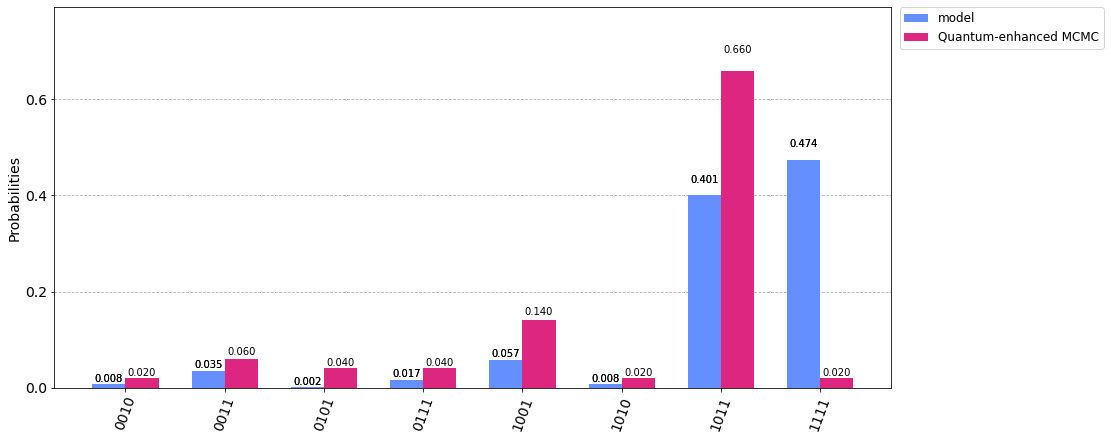

In [12]:
# symmetric uniform transition matrix for uniform transition rule
num_spins=4
num_elems=2**(num_spins)
transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy
N_hops=50
dict_states_quantum_mcmc, mcmc_hist =quantum_enhanced_mcmc(N_hops, num_spins, num_elems, model, alpha, num_trotter_steps=10, return_history=True, return_last_n_states=50)

# get actual probability distribution
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in dict_states_quantum_mcmc.keys() ] )
# plot actual prob distribution as well as one obtained from MCMC
plot_histogram( [transits_bltz, dict_states_quantum_mcmc] , figsize=(15, 7), legend= ['model', 'Quantum-enhanced MCMC' ])#, sort= 'value_desc')

In [9]:
mcmc_hist

,acceptance
0,True
1,True
2,True
3,True
4,False
5,False
6,True
7,True
8,True
9,True


In [7]:
l = [1,2,3]
l[-5:]

[1, 2, 3]

In [ ]:
initialise_qc(2, '11')[0].qubits

[Qubit(QuantumRegister(2, 'spin'), 0), Qubit(QuantumRegister(2, 'spin'), 1)]

In [ ]:
observables= ['rejection_count']
observable_dict = dict([ ( elem, []  ) for elem in observables ])

In [ ]:
observable_dict['rejection_count'].append(0.2)

In [ ]:
observable_dict['rejection_count']

[0.1, 0.2]

In [ ]:
observable_df = pd.DataFrame(observable_dict)
# observable_df.append([[0.4]])

In [ ]:
observable_df

,rejection_count
0,0.1
1,0.2


In [ ]:
## class for updating; 
# requirements ->
# update_strategy = {classical, quantum}
# measurements = {} : list of observables to measure over iterations



def run_mcmc_sampling():
    